In [1]:
!pip install yfinance

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [5]:
# Loading the Apple.Inc Stock Data

import yfinance as yf
from datetime import date, timedelta, datetime 

end_date = date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date 
start_date = '1990-01-01' # Beginning date for our historical data retrieval 

df = yf.download('AAPL', start=start_date, end=end_date)# Function used to fetch the data 

[*********************100%%**********************]  1 of 1 completed


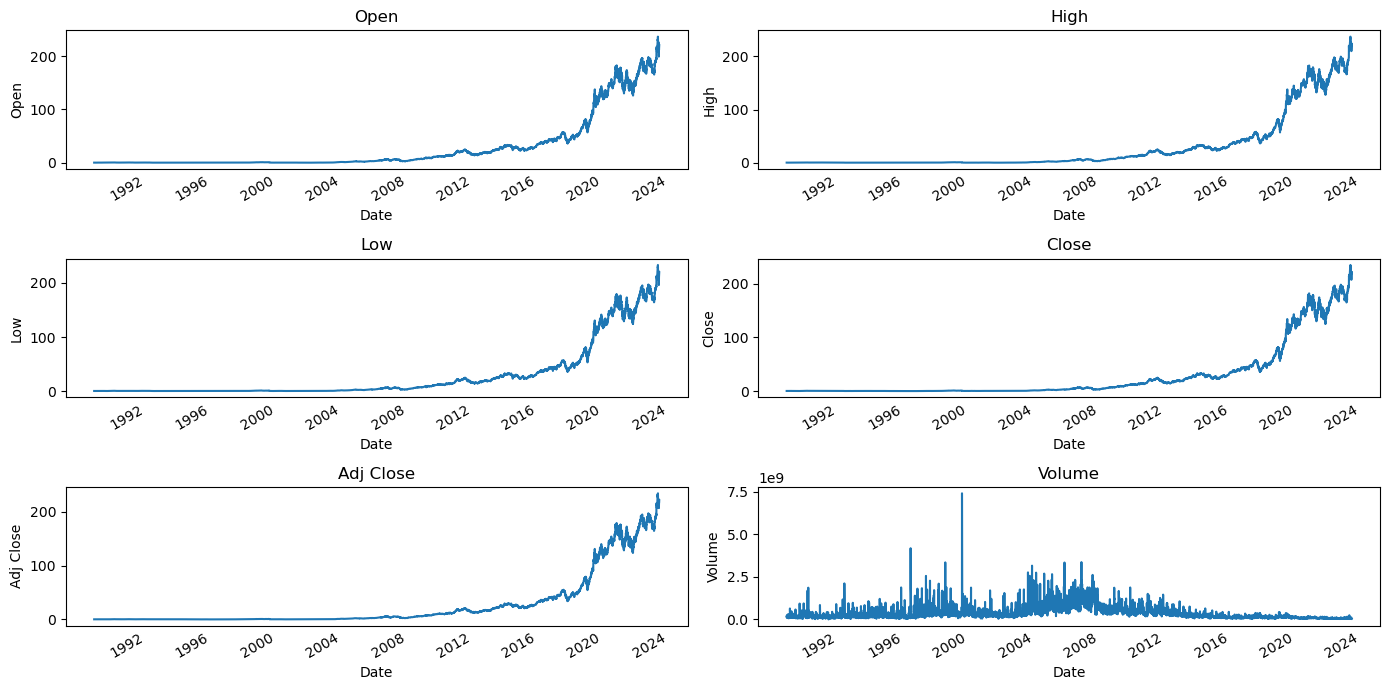

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def data_plot(df):
    df_plot = df.copy()
    ncols = 2
    nrows = int(np.ceil(df_plot.shape[1] / ncols))  # Ensure proper rounding
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 7))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < df_plot.shape[1]:  # Ensure no IndexError
            sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
            ax.set_title(df_plot.columns[i])  # Set the column name as title
            ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        else:
            ax.axis('off')  # Turn off any extra subplot that has no data
    
    fig.tight_layout()
    plt.show()

# Assuming df is your DataFrame containing time-series data
data_plot(df)

In [8]:
# Train-Test Split 
# Setting 80 percent data for training
training_data_len = math.ceil(len(df) * .8)
training_data_len
 
#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6977, 1) (1744, 1)


In [9]:
# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6977, 1)

In [10]:
# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(1744, 1)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test

[[0.00486252]
 [0.00546016]
 [0.00551449]
 [0.00540584]
 [0.00535148]]
[0.02104896] [0.02060005] [0.02323117] [0.01981445] [0.01871712]


In [19]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])  # Input sequence
    y_train.append(scaled_train[i+sequence_length])    # Target is the next value after the sequence

# Convert data to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Check shapes
X_train.shape, y_train.shape

(torch.Size([6927, 50, 1]), torch.Size([6927, 1]))

In [18]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+sequence_length])  # Target is the next value after the sequence

# Convert data to numpy arrays
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Check shapes
X_test.shape, y_test.shape

(torch.Size([1714, 30, 1]), torch.Size([1714, 1]))

In [16]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)  # Mapping the LSTM output to the final output
        
    def forward(self, x): 
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device) 
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  
        
        # Apply the linear layer on the output of the last time step
        out = self.linear(out[:, -1, :])  # We use only the last output in the sequence
        return out

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [24]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
num_epochs = 50
train_hist = []
test_hist = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average training loss
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test).detach()  # Detach to save memory
        test_loss = loss_fn(predictions_test, batch_y_test)

        total_test_loss += test_loss.item()

        # Calculate average test loss
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.0001, Test Loss: 0.0003
Epoch [20/50] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [30/50] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [40/50] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [50/50] - Training Loss: 0.0000, Test Loss: 0.0001


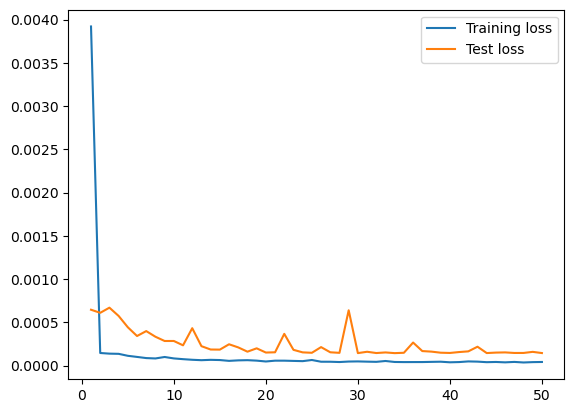

In [28]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [31]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert the test data to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]  # Last sequence in the test data
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)

        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, -1]  # Extract the last predicted value

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value)

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Generate future dates
last_date = test_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

# Print the forecasted values and future dates for verification
print(forecasted_values)
print(future_dates)

(30,)
[0.90813917, 0.9063727, 0.9049096, 0.9044318, 0.90407366, 0.9036074, 0.90309644, 0.9025846, 0.90207857, 0.90157837, 0.90108496, 0.90059954, 0.9001227, 0.8996546, 0.8991955, 0.8987452, 0.89830357, 0.8978706, 0.8974461, 0.8970298, 0.89662164, 0.8962216, 0.89582926, 0.8954447, 0.89506745, 0.89469755, 0.8943349, 0.89397913, 0.89363027, 0.8932881]
DatetimeIndex(['2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18',
               '2024-08-19', '2024-08-20', '2024-08-21', '2024-08-22',
               '2024-08-23', '2024-08-24', '2024-08-25', '2024-08-26',
               '2024-08-27', '2024-08-28', '2024-08-29', '2024-08-30',
               '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03',
               '2024-09-04', '2024-09-05', '2024-09-06', '2024-09-07',
               '2024-09-08', '2024-09-09', '2024-09-10', '2024-09-11',
               '2024-09-12', '2024-09-13'],
              dtype='datetime64[ns]', freq='D')


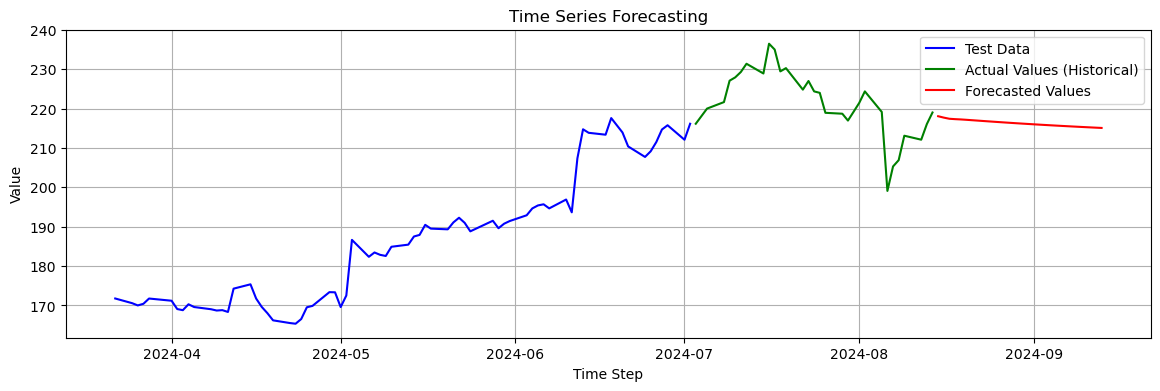

In [33]:
# Set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4]

# Plot the last 70 points of test data (the 40 prior and 30 used as input to forecasting)
plt.plot(test_data.index[-100:-30], test_data.Open[-100:-30], label='Test Data', color='blue')

# Reverse the scaling transformation for the historical input (used as the last known actual values)
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

# Plot the historical actual values used for forecasting
plt.plot(test_data.index[-30:], original_cases, label='Actual Values (Historical)', color='green')

# Reverse the scaling transformation for forecasted values
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()

# Plot the forecasted values
plt.plot(combined_index[-30:], forecasted_cases, label='Forecasted Values', color='red')

# Add labels and title to the plot
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

# Display the plot
plt.show()